In [1]:
from keras.layers import LSTM, TimeDistributed, concatenate, Input, Dense, RepeatVector, Lambda
from keras.models import Model
from keras.activations import relu, sigmoid, tanh
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import keras.backend as K
from keras.utils import plot_model

import numpy as np
import numpy.random as rnd

from skimage.util import view_as_windows

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

Using TensorFlow backend.
/home/gmiebs/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gmiebs/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gmiebs/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gmiebs/.local/lib/python3.6/site-packages/tensorflow/python

In [2]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [3]:
def prepare_model(static, dynamic, k, window):
    input_dynamic = Input(shape=(window, 1), name="input_dynamic")
    input_static = Input(shape=(static,), name="input_static")
    latent = Dense(k[0], activation=relu)(input_static)
    dense_h = Dense(k[0])(latent)
    dense_c = Dense(k[0])(latent)
    lstm_layer, state_h, state_c = LSTM(k[0], return_sequences=True, return_state=True)(input_dynamic,
                                                                                        initial_state=[dense_h,
                                                                                                       dense_c])

    for x in k[1:-1]:
        concat_h = concatenate([dense_h, state_h])
        dense_h = Dense(x)(concat_h)
        concat_c = concatenate([dense_c, state_c])
        dense_c = Dense(x)(concat_c)
        lstm_layer, state_h, state_c = LSTM(x, return_sequences=True, return_state=True)(lstm_layer,
                                                                                         initial_state=[dense_h,
                                                                                                        dense_c])
    x = k[-1]
    concat_h = concatenate([dense_h, state_h])
    dense_h = Dense(x)(concat_h)
    concat_c = concatenate([dense_c, state_c])
    dense_c = Dense(x)(concat_c)
    lstm_layer, state_h, state_c = LSTM(x, return_state=True)(lstm_layer, initial_state=[dense_h, dense_c])
    concat = concatenate([lstm_layer, latent])
    z_mean = Dense(x, name='z_mean')(concat)
    z_log_var = Dense(x, name='z_log_var')(concat)
    
    
    z = Lambda(sampling, output_shape=(x,), name='z')([z_mean, z_log_var])
    
    
    
    state_h = Dense(k[-2], activation=relu)(z)
    dense_h = Dense(k[-2], activation=relu)(z)
    state_c = Dense(k[-2], activation=relu)(z)
    dense_c = Dense(k[-2], activation=relu)(z)
    lstm_layer = RepeatVector(window)(z)

    for x in np.flip(k[:-1]):
        concat_h = concatenate([dense_h, state_h])
        dense_h = Dense(x)(concat_h)
        concat_c = concatenate([dense_c, state_c])
        dense_c = Dense(x)(concat_c)
        lstm_layer, state_h, state_c = LSTM(x, return_sequences=True, return_state=True)(lstm_layer,
                                                                                         initial_state=[dense_h,
                                                                                                        dense_c])

    result_series = TimeDistributed(Dense(1))(lstm_layer)
    concat = concatenate([state_h, state_c])
    result_sigmoid = Dense(static-3, activation=sigmoid)(concat)
    result_relu = Dense(3, activation=tanh)(concat)

    model = Model(inputs=[input_dynamic, input_static], outputs=[result_series, result_sigmoid, result_relu])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    print(model.summary())
    return model

In [4]:
def rolling_window(a, window, step=1):
        q = view_as_windows(a, [window, a.shape[-1]], step)
        return q[:, 0]

In [5]:
def fit(static, dynamic, window, model, step=1):
    dynamic_data = np.empty((0, window, 1), np.float)
    helper = []
    for d in dynamic:
        new_data = rolling_window(d, window, step)
        helper.append(len(new_data))
        dynamic_data = np.append(dynamic_data, new_data, axis=0)
    print(len(helper))
    static_data = np.repeat(static, helper, axis=0)
    order = rnd.permutation(len(static_data))

    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    bst_model_path = 'autoencoder.h5'
    checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True, monitor='val_loss')

    size = int(static_data.shape[0] * 0.9)
    training_dynamic, training_static = dynamic_data[order[:size]], static_data[order[:size]]
    testing_dynamic, testing_static = dynamic_data[order[size:]], static_data[order[size:]]
    print(training_dynamic.shape, training_static.shape)
    print(testing_dynamic.shape, testing_static.shape)
    model.fit([training_dynamic, training_static], 
              [training_dynamic[..., 0:1], training_static[..., 3:], training_static[..., 0:3]],
                   epochs=500,
                   batch_size=512,
                   callbacks=[early_stopping, checkpoint],
                   validation_data=([testing_dynamic, testing_static], 
                                    [testing_dynamic[..., 0:1], testing_static[..., 3:], testing_static[..., 0:3]]))


In [7]:
static = pd.read_csv("../../data/processed/Static_normalize.txt", sep=";", header=None)
tmp = static[2].copy()
static[2] = static[1]
static[1] = tmp

tmp = static[10].copy()
static[10] = static[2]
static[2] = tmp

tmp = static[11].copy()
static[11] = static[3]
static[3] = tmp

static = static.drop([len(static.columns)-1, 0], axis=1)
static

,1,2,3,4,5,6,7,8,9,10,11
0,-0.01582,0.094025,0.939266,0,0,1,0,0,0,0,0
1,-0.01727,0.300320,0.373958,0,0,0,0,0,0,1,1
2,-0.01727,0.340923,0.376153,1,0,0,0,0,0,1,0
3,-1.00000,0.311557,0.662659,0,0,0,0,0,0,1,1
4,-0.66485,0.341965,0.517157,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
709178,-0.23293,0.339311,0.374098,1,0,0,0,0,0,1,0
709179,-0.01582,0.098094,0.942467,0,1,0,0,0,0,0,0
709180,-0.01582,0.095201,0.942126,0,0,1,0,0,0,0,0
709181,-0.01582,0.088238,0.941815,0,0,0,0,0,0,0,1


In [8]:
dynamic = pd.read_csv("../../data/processed/Dynamic_normalize.txt", sep=";", usecols=np.arange(169)+1, header=None)
# dynamic = dynamic.drop([0], axis=1)
dynamic

,1,2,3,4,5,6,7,8,9,10,...,160,161,162,163,164,165,166,167,168,169
0,0.057490,0.057124,0.062952,0.064715,0.064390,0.062659,0.062798,0.058540,0.058180,0.058329,...,-0.023369,-0.024250,-0.025100,-0.019371,-0.018917,-0.019995,-0.025484,-0.026294,-0.025961,-0.025624
1,0.136425,0.136774,0.136416,0.135855,0.135291,0.134110,0.133745,0.133173,0.132598,0.132229,...,-0.062633,-0.068625,-0.069730,-0.070427,-0.071117,-0.072183,-0.071521,-0.072582,-0.073252,-0.075575
2,0.128603,0.127866,0.127341,0.128434,0.127911,0.128892,0.128157,0.127633,0.127108,0.124606,...,-0.067286,-0.068274,-0.069644,-0.070988,-0.071925,-0.075996,-0.076872,-0.079490,-0.080670,-0.081495
3,0.175690,0.175215,0.171896,0.171411,0.171110,0.170809,0.170320,0.169831,0.170275,0.169973,...,-0.097057,-0.097587,-0.098437,-0.095193,-0.096064,-0.096599,-0.098592,-0.099113,-0.099950,-0.100780
4,0.159655,0.159059,0.158461,0.158035,0.157608,0.157004,0.157188,0.156583,0.156152,0.155719,...,-0.084983,-0.085773,-0.086555,-0.087646,-0.088723,-0.089480,-0.090230,-0.092476,-0.093498,-0.095379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709178,0.132718,0.132010,0.131508,0.131004,0.130286,0.129565,0.129053,0.129287,0.128775,0.128045,...,-0.065243,-0.066664,-0.068056,-0.069021,-0.069974,-0.071300,-0.072603,-0.073509,-0.074404,-0.075653
709179,0.055660,0.055806,0.061750,0.061882,0.063433,0.063093,0.063222,0.063350,0.063010,0.062667,...,-0.029436,-0.030158,-0.030863,-0.030598,-0.030330,-0.022096,-0.023049,-0.022693,-0.022331,-0.023274
709180,0.056546,0.056171,0.056323,0.067704,0.067830,0.053825,0.053431,0.053591,0.053750,0.053356,...,-0.014089,-0.015517,-0.016823,-0.027215,-0.026900,-0.027674,-0.028427,-0.028125,0.024911,0.036333
709181,0.059422,0.059580,0.059738,0.059398,0.059056,0.059216,0.059375,0.059033,0.058689,0.058850,...,-0.009348,-0.008278,-0.007047,-0.009495,-0.011429,-0.010572,-0.009639,-0.011550,-0.013187,0.032121


In [9]:
dynamic = dynamic[np.abs(static[2]) <= 1]
static = static[np.abs(static[2]) <= 1]

In [10]:
mask = ~dynamic.isna().any(axis=1)
static = static[mask]
dynamic = dynamic[mask]

In [11]:
dynamic.shape, static.shape

((705467, 169), (705467, 11))

In [12]:
model = prepare_model(11, 1, [128,64,32,16,8], 169)
model.load_weights("../../model/autoencoder.h5")






Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_static (InputLayer)       (None, 11)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          1536        input_static[0][0]               
__________________________________________________________________________________________________
input_dynamic (InputLayer)      (None, 169, 1)       0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          16512       dense_1[0][0]                    
_______________________________________________________________________________________

In [13]:
dynamic = np.array(dynamic).reshape(dynamic.shape[0], -1, 1)

In [26]:
fit(static, dynamic, 169, model)

/home/gmiebs/.local/lib/python3.6/site-packages/skimage/util/shape.py:246: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


1000
(900, 169, 1) (900, 11)
(100, 169, 1) (100, 11)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 900 samples, validate on 100 samples
Epoch 1/500
900/900 [==============================] - 12s 14ms/step - loss: 0.6425 - time_distributed_1_loss: 0.0330 - dense_17_loss: 0.2590 - dense_18_loss: 0.3504 - time_distributed_1_mean_absolute_error: 0.1503 - dense_17_mean_absolute_error: 0.5069 - dense_18_mean_absolute_error: 0.4940 - val_loss: 0.6388 - val_time_distributed_1_loss: 0.0332 - val_dense_17_loss: 0.2584 - val_dense_18_loss: 0.3472 - val_time_distributed_1_mean_absolute_error: 0.1508 - val_dense_17_mean_absolute_error: 0.5063 - val_dense_18_mean_absolute_error: 0.4898
Epoch 2/500
900/900 [==============================] - 3s 4ms/step - loss: 0.6025 - time_distributed_1_loss: 0.0278 - dense_17_loss: 0.2570 - dense_18_loss: 0.3177 - time_distributed_1_mean_absolute_error: 0.1365 - dense_17_mean_absolute_error: 0.5051 - dense_1

KeyboardInterrupt: 

In [72]:
st = np.array(static)[150:151]
dy = dynamic[150:151]

In [76]:
st

array([[0.211414  , 0.15040117, 0.8189564 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        1.        ]])

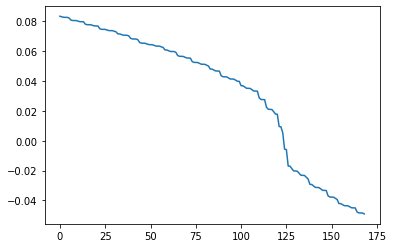

In [73]:
plt.plot(dy[0])

In [77]:
a,b,c = model.predict([dy.reshape(1,169,1), st])

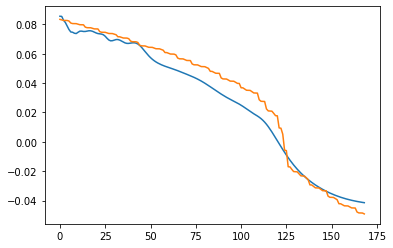

In [78]:
plt.plot(a[0])
plt.plot(dy[0])

In [79]:
print(st)

[[0.211414   0.15040117 0.8189564  0.         0.         0.
  0.         0.         0.         1.         1.        ]]


In [80]:
print(b)

[[2.9474497e-05 7.9602003e-05 0.0000000e+00 2.2053719e-06 6.2093139e-04
  6.8873167e-05 9.9995506e-01 9.9913651e-01]]


In [81]:
print(c)

[[0.2117146  0.15219848 0.81815153]]


In [40]:
dynamic = dynamic.reshape(705467, -1)
dynamic.shape

(705467, 169)

In [41]:
dynamic

array([[ 0.05749036,  0.05712436,  0.06295237, ..., -0.02629427,
        -0.02596146, -0.02562432],
       [ 0.1364254 ,  0.13677365,  0.13641596, ..., -0.0725819 ,
        -0.07325195, -0.07557462],
       [ 0.12860267,  0.12786582,  0.12734123, ..., -0.07948995,
        -0.08066989, -0.08149545],
       ...,
       [ 0.05654614,  0.05617123,  0.05632309, ..., -0.02812511,
         0.02491116,  0.03633271],
       [ 0.05942156,  0.05958002,  0.05973805, ..., -0.01155005,
        -0.01318665,  0.03212136],
       [ 0.0609969 ,  0.06125217,  0.06102208, ...,  0.01333494,
         0.02985707,  0.03037517]])

In [71]:
plt.plot(dynamic[np.sum(np.abs(dynamic), axis=1) > 50][6])

IndexError: index 6 is out of bounds for axis 0 with size 6

In [61]:
d = dynamic[np.sum(np.abs(dynamic), axis=1) > 50][3].reshape(1,-1,1)
s = static[np.sum(np.abs(dynamic), axis=1) > 50]
d, s

(array([[[-0.56703017],
         [-0.56701105],
         [-0.56693961],
         [-0.56686815],
         [-0.56684903],
         [-0.56682991],
         [-0.56696781],
         [-0.56689635],
         [-0.56687724],
         [-0.56685812],
         [-0.56678665],
         [-0.5665319 ],
         [-0.5664604 ],
         [-0.56644126],
         [-0.56642213],
         [-0.56635061],
         [-0.56627908],
         [-0.56625994],
         [-0.5662408 ],
         [-0.56616925],
         [-0.5660977 ],
         [-0.56607855],
         [-0.56605941],
         [-0.56598784],
         [-0.56591626],
         [-0.56589711],
         [-0.56587796],
         [-0.56580637],
         [-0.56573477],
         [-0.56571561],
         [-0.56569645],
         [-0.56562484],
         [-0.56555322],
         [-0.56553405],
         [-0.56551489],
         [-0.56544325],
         [-0.56537161],
         [-0.56535244],
         [-0.56533327],
         [-0.56526161],
         [-0.56518994],
         [-0.565

In [65]:
s = static.loc[195502]
s

1    -1.000000
2    -0.192275
3     0.583500
4     0.000000
5     0.000000
6     0.000000
7     1.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
Name: 195502, dtype: float64

In [66]:
a,b,c = model.predict([d,np.array([s])])

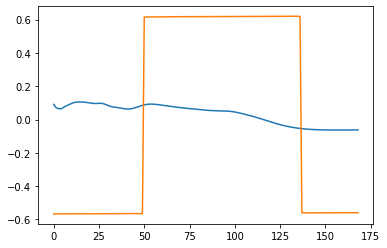

In [68]:
plt.plot(a[0])
plt.plot(d[0])

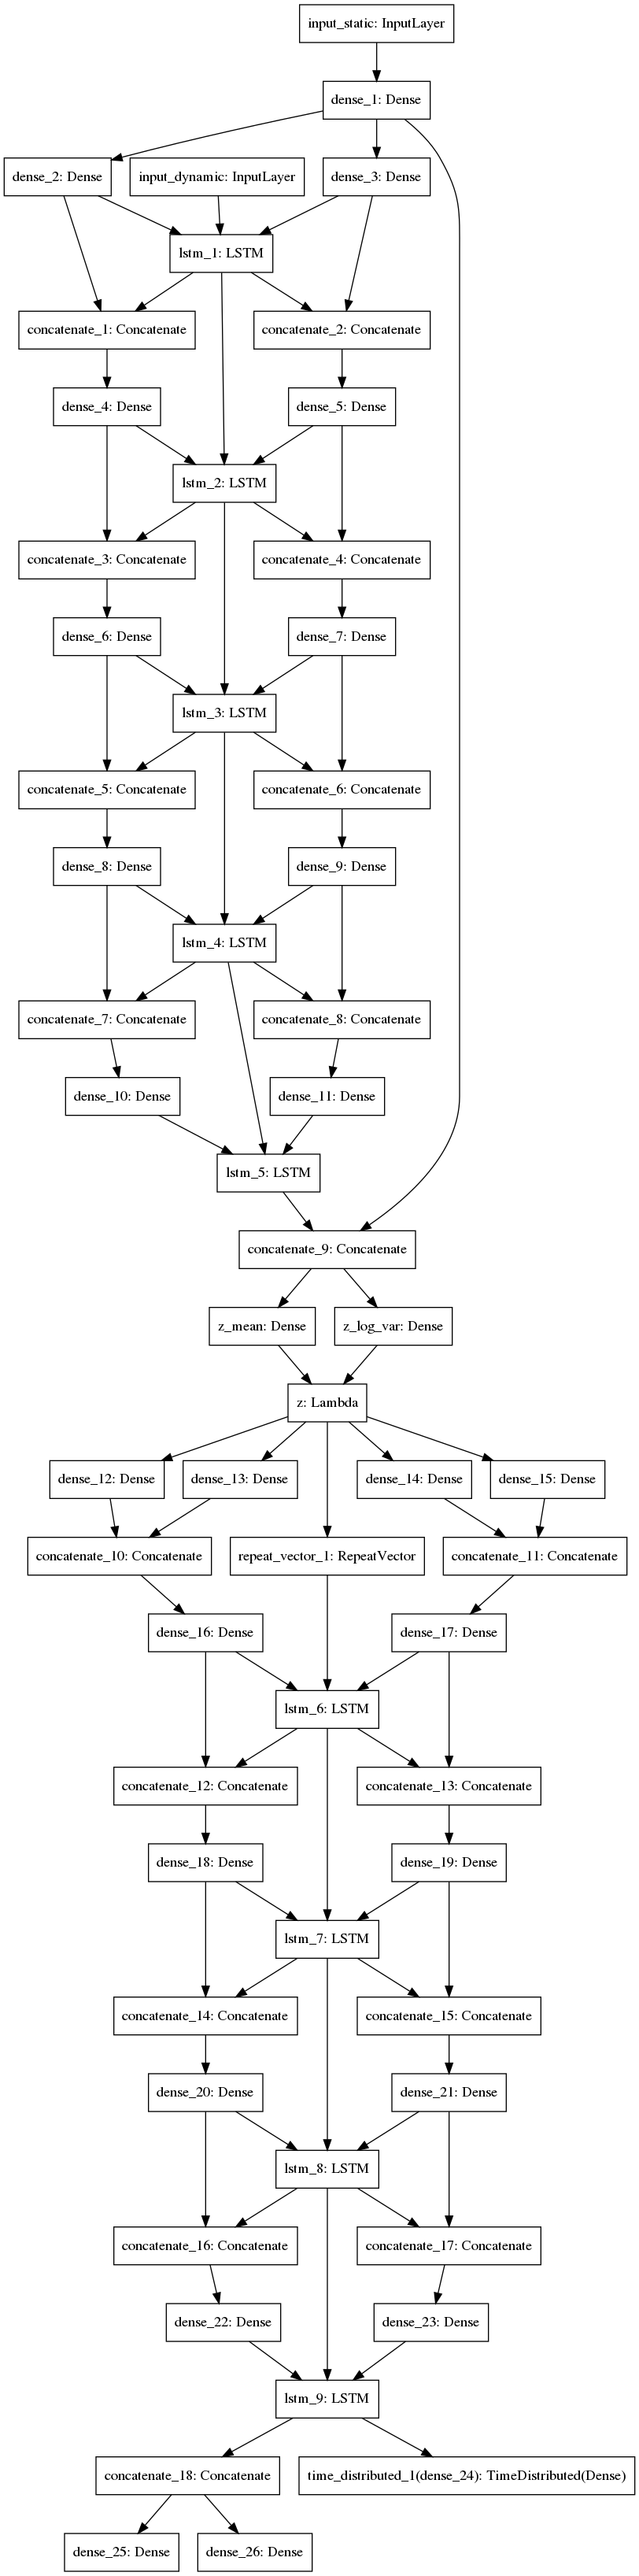

In [82]:
plot_model(model)

In [88]:
encoder = Model(inputs=[model.get_layer("input_dynamic").input, model.get_layer("input_static").input], 
                output=model.get_layer("z_mean").output)

/home/gmiebs/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("z_...)`
  """Entry point for launching an IPython kernel.


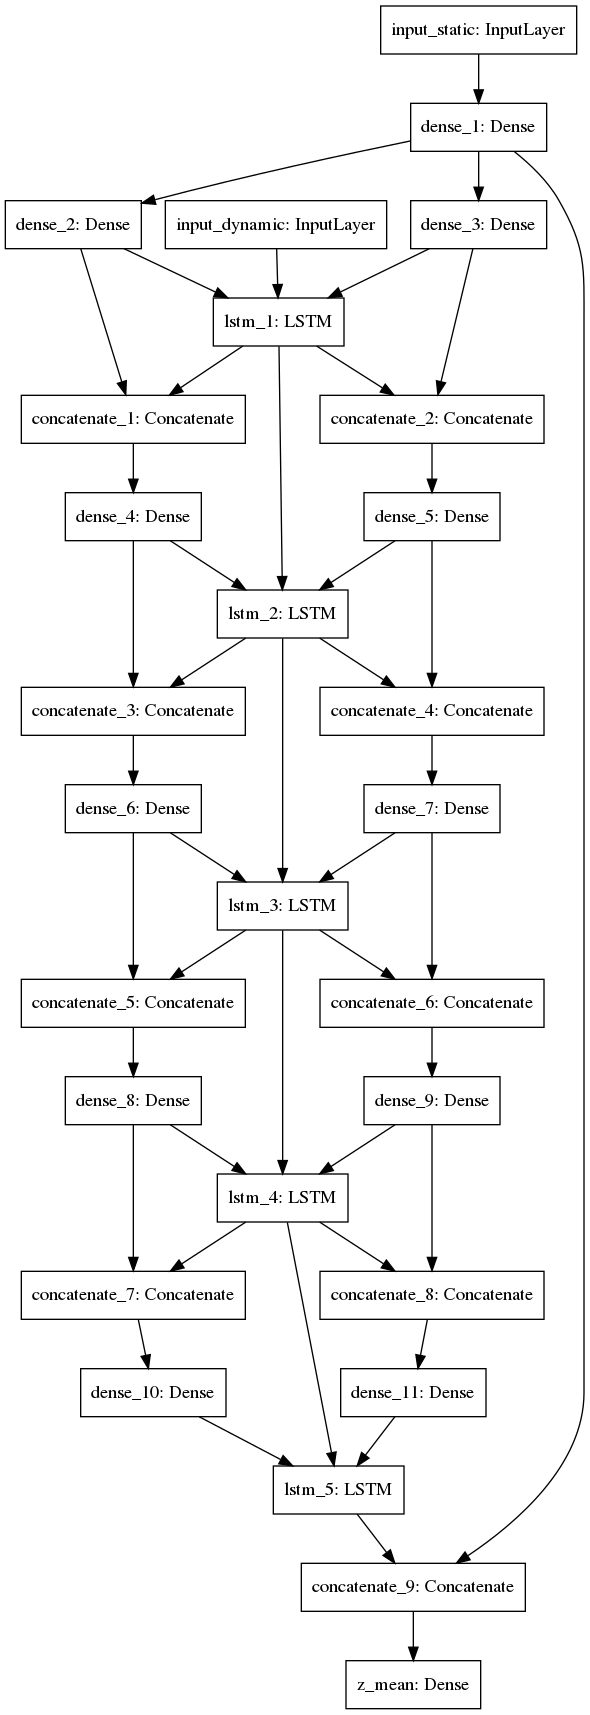

In [89]:
plot_model(encoder)

In [97]:
model.layers

In [92]:
model.outputs

[<tf.Tensor 'time_distributed_1/Reshape_1:0' shape=(?, 169, 1) dtype=float32>,
 <tf.Tensor 'dense_25/Sigmoid:0' shape=(?, 8) dtype=float32>,
 <tf.Tensor 'dense_26/Tanh:0' shape=(?, 3) dtype=float32>]

In [102]:
decoder = Model(input=model.get_layer("z").input, outputs=[x.output for x in model.layers[-3:]])

/home/gmiebs/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`
  """Entry point for launching an IPython kernel.
/home/gmiebs/.local/lib/python3.6/site-packages/keras/engine/network.py:186: UserWarning: Model inputs must come from `keras.layers.Input` (thus holding past layer metadata), they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to your model was not an Input tensor, it was generated by layer z_mean.
Note that input tensors are instantiated via `tensor = keras.layers.Input(shape)`.
The tensor that caused the issue was: z_mean/BiasAdd:0
  str(x.name))
/home/gmiebs/.local/lib/python3.6/site-packages/keras/engine/network.py:186: UserWarning: Model inputs must come from `keras.layers.Input` (thus holding past layer metadata), they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to your 

ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_static:0", shape=(?, 11), dtype=float32) at layer "input_static". The following previous layers were accessed without issue: []

In [98]:
model.layers[-3:]